In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline
from pathlib import Path
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.preprocessing import OneHotEncoder

In [3]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

In [4]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [5]:
stores.shape

(54, 5)

In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [7]:
stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [8]:
stores.duplicated().sum()

0

In [9]:
stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [10]:
stores['state'].value_counts()

Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja                               1
Esmeraldas                         1
Name: state, dtype: int64

In [11]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [13]:
train['date'] = pd.to_datetime(train['date'],infer_datetime_format = True)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [15]:
train['family'].value_counts().sort_values(ascending = False)[0:20]

AUTOMOTIVE             90936
BABY CARE              90936
BEAUTY                 90936
BEVERAGES              90936
BOOKS                  90936
BREAD/BAKERY           90936
CELEBRATION            90936
CLEANING               90936
DAIRY                  90936
DELI                   90936
EGGS                   90936
FROZEN FOODS           90936
GROCERY I              90936
GROCERY II             90936
HARDWARE               90936
HOME AND KITCHEN I     90936
HOME AND KITCHEN II    90936
HOME APPLIANCES        90936
HOME CARE              90936
LADIESWEAR             90936
Name: family, dtype: int64

In [16]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [17]:
train.shape

(3000888, 6)

In [18]:
train['onpromotion'].unique()

array([  0,   3,   5,   1,  56,  20,  19,   2,   4,  18,  17,  12,   6,
         7,  10,   9,  50,   8,  16,  42,  51,  13,  15,  47,  21,  40,
        37,  54,  24,  58,  22,  59,  11,  45,  25,  55,  26,  43,  35,
        14,  28,  46,  36,  32,  53,  57,  27,  39,  41,  30,  29,  49,
        23,  48,  44,  38,  31,  52,  33,  34,  61,  60, 116,  86,  73,
       113, 102,  68, 104,  93,  70,  92, 121,  72, 178, 174, 161, 118,
       105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186,
       140, 149, 145, 169, 188,  62,  84, 111,  65, 107,  63, 101,  87,
       125,  94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147,
       151, 189,  79,  74, 110,  64,  67,  99, 123, 157, 117, 150, 182,
       162, 160, 194, 135, 190,  69, 108,  89, 126, 156, 103, 146, 132,
       177, 164, 176, 112,  75, 109,  91, 128, 175, 187, 148, 137, 184,
       196, 144, 158, 119, 106,  66, 100,  90, 120, 115,  98, 159, 152,
       185, 139, 143,  80, 124,  71, 134, 193,  78,  88, 122, 13

In [19]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [20]:
test.shape

(28512, 5)

In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [22]:
test['date'] = pd.to_datetime(test['date'],infer_datetime_format = True)

In [23]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [24]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [25]:
holidays.shape

(350, 6)

In [26]:
holidays['date'] = pd.to_datetime(holidays['date'],infer_datetime_format = True)

In [27]:
holidays.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

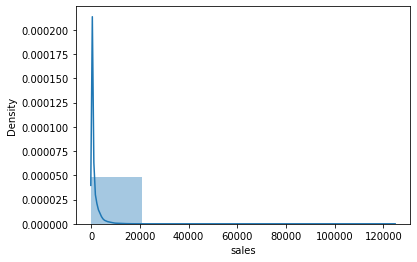

In [28]:
sns.distplot(train['sales'],bins=6)
plt.show()

In [29]:
shop_sales = train.copy()

In [30]:
shop_sales = shop_sales.set_index('date').to_period('D')

In [31]:
shop_sales = shop_sales.set_index(['store_nbr', 'family'], append=True)

In [32]:
shop_sales

id     sales  \
date       store_nbr family                                          
2013-01-01 1         AUTOMOTIVE                        0     0.000   
                     BABY CARE                         1     0.000   
                     BEAUTY                            2     0.000   
                     BEVERAGES                         3     0.000   
                     BOOKS                             4     0.000   
...                                                  ...       ...   
2017-08-15 9         POULTRY                     3000883   438.133   
                     PREPARED FOODS              3000884   154.553   
                     PRODUCE                     3000885  2419.729   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000   
                     SEAFOOD                     3000887    16.000   

                                                 onpromotion  
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE                            0  
                     BABY CARE                             0  
                     BEAUTY                                0  
                     BEVERAGES                             0  
                     BOOKS                                 0  
...                                                      ...  
2017-08-15 9         POULTRY                               0  
                     PREPARED FOODS                        1  
                     PRODUCE                             148  
                     SCHOOL AND OFFICE SUPPLIES            8  
                     SEAFOOD                               0  

[3000888 rows x 3 columns]

In [33]:
average = shop_sales.groupby('date').mean()['sales']

average

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
                 ...    
2017-08-11    463.733851
2017-08-12    444.798280
2017-08-13    485.768618
2017-08-14    427.004717
2017-08-15    427.980884
Freq: D, Name: sales, Length: 1684, dtype: float64

In [34]:
avg_sales = average.to_frame()

In [35]:
time = np.arange(len(avg_sales.index))

avg_sales['time'] = time 

In [36]:
X = avg_sales.loc[:, ['time']]
y = avg_sales.loc[:, 'sales']


In [37]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

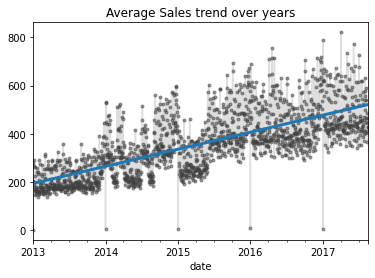

In [38]:
ax = y.plot(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Average Sales trend over years');

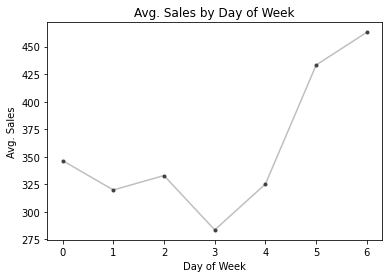

In [39]:
train_df = train.copy()
train_df=train_df.set_index('date')
temp=train_df.groupby(train_df.index.day_of_week)['sales'].mean().to_frame()

temp.plot(color="0.75", style=".-", markeredgecolor="0.25",
          markerfacecolor="0.25", legend=False)
plt.xlabel('Day of Week')
plt.ylabel('Avg. Sales')
plt.title('Avg. Sales by Day of Week')
plt.show()

In [40]:
average_sales=train_df.groupby(['date'])['sales','onpromotion'].sum().reset_index()
average_sales

,date,sales,onpromotion
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,0
2,2013-01-03,361461.231124,0
3,2013-01-04,354459.677093,0
4,2013-01-05,477350.121229,0
...,...,...,...
1679,2017-08-11,826373.722022,14179
1680,2017-08-12,792630.535079,8312
1681,2017-08-13,865639.677471,9283
1682,2017-08-14,760922.406081,8043


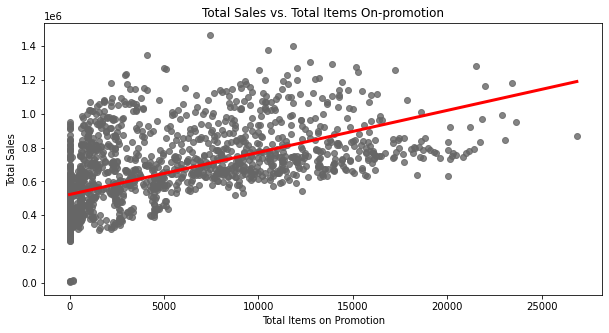

In [41]:
plt.figure(figsize=(10,5))
sns.regplot(data=average_sales,x='onpromotion',y='sales',ci=None,
            scatter_kws={'color':'0.4'},line_kws={'color':'red','linewidth':3})
plt.xlabel('Total Items on Promotion')
plt.ylabel('Total Sales')
plt.title('Total Sales vs. Total Items On-promotion')
plt.show()

In [42]:
np.round(average_sales[['sales','onpromotion']].corr().iloc[0,1],4)

0.5749

**Observation: The correlation is 0.5749**